In [2]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance

In [3]:
import numpy as np
import pandas as pd
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from copy import copy

In [4]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
stress_test_assets = ['^GSPC']
all_assets = selected_assets + stress_test_assets

existing_assets = [c for c in all_assets if c in data.columns]
data = data[existing_assets]
print(f"Assets found: {len(existing_assets)} / {len(all_assets)}")
print(f"Observations: {len(data)} ({np.round(len(data)/252, 2)} years)")

data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')
print(f"After cleaning: {len(data_clean)} obs")
print(f"Date range: {data_clean.index[0].date()} → {data_clean.index[-1].date()}")

pnl = np.diff(np.log(data_clean.values), axis=0)
pnl = pd.DataFrame(pnl, index=data_clean.index[1:], columns=data_clean.columns)
print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")

investable_mask = np.array([col in selected_assets for col in pnl.columns])
n_investable = investable_mask.sum()
print(f"Investable: {n_investable}, Stress-test: {len(pnl.columns) - n_investable}")

prior_stats = ft.simulation_moments(pnl)
np.round(prior_stats, 3)

Assets found: 13 / 13
Observations: 2471 (9.81 years)
After cleaning: 2471 obs
Date range: 2016-01-04 → 2025-11-11
Returns: 2470 days × 13 assets
Investable: 12, Stress-test: 1


,Mean,Volatility,Skewness,Kurtosis
NVDA,0.002,0.031,0.083,9.574
ISRG,0.001,0.020,-0.043,11.279
APO,0.001,0.024,-0.013,12.979
DECK,0.001,0.027,-0.606,14.204
COST,0.001,0.014,-0.525,11.839
CAT,0.001,0.019,-0.247,7.875
BTU,0.001,0.073,17.861,644.789
SHW,0.001,0.017,-0.713,18.313
NRG,0.001,0.025,0.167,16.473
NFLX,0.001,0.027,-1.798,35.876


In [5]:
covariance_matrix = ft.covariance_matrix(pnl).values
means = prior_stats['Mean'].values

S, I = pnl.shape
R = pnl.values

upper_bounds = np.where(investable_mask, 0.25, 0.0)
G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((upper_bounds, np.zeros(I)))

alpha = 0.9
cvar_opt = ft.MeanCVaR(R, G, h, alpha=alpha)

In [6]:
B = 1000
P = 9
pf_index = 4
N = 100
np.random.seed(3)
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

frontier = cvar_opt.efficient_frontier(P)
frontier_results = np.full((P, 2), np.nan)
frontier_results[:, 0] = means @ frontier
frontier_results[:, 1] = ft.portfolio_cvar(frontier, R)

In [7]:
p = np.ones((S, 1)) / S
frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)

for b in range(B):
    if (b + 1) % 100 == 0:
        print(f"Progress: {b+1}/{B}")
    
    means_uncertainty = np.mean(return_sim[:, b, :], axis=0)
    q = ft.entropy_pooling(p, A=R.T, b=means_uncertainty[:, np.newaxis])
    
    R_weighted = R * q * S
    cvar_opt_b = ft.MeanCVaR(R_weighted, G, h, alpha=alpha)
    
    frontier_mean[:, :, b] = cvar_opt_b.efficient_frontier(P)
    mean_results[:, 0, b] = means @ frontier_mean[:, :, b]
    mean_results[:, 1, b] = ft.portfolio_cvar(frontier_mean[:, :, b], R)

Progress: 100/1000
Progress: 200/1000
Progress: 300/1000
Progress: 400/1000
Progress: 500/1000
Progress: 600/1000
Progress: 700/1000
Progress: 800/1000
Progress: 900/1000
Progress: 1000/1000


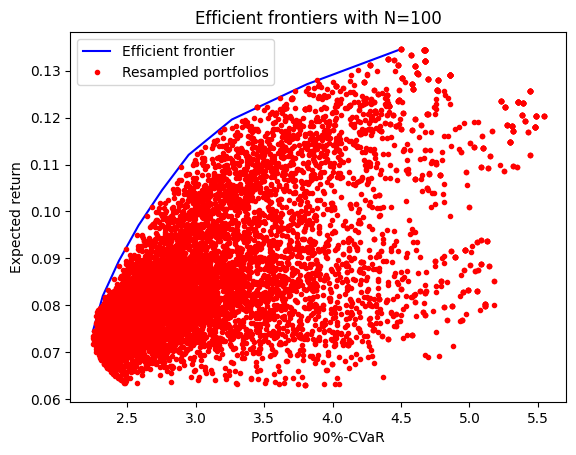

In [8]:
plt.plot(100 * frontier_results[:, 1], 100 * frontier_results[:, 0], 'b-')
plt.plot(100 * mean_results[:, 1, :], 100 * mean_results[:, 0, :], 'r.')
plt.legend(['Efficient frontier', 'Resampled portfolios'])
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio 90%-CVaR')
plt.show()

In [9]:
def exposure_stacking(L, frontier, num_samples):
    partition_size = num_samples // L
    M = frontier[:, pf_index, :num_samples].T
    P_mat = np.zeros((num_samples, num_samples))
    q_vec = np.zeros((num_samples, 1))
    
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P_mat = P_mat + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q_vec = q_vec + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    
    P_mat = matrix(2 * partition_size * P_mat)
    q_vec = matrix(-2 * q_vec)
    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))
    G_qp = matrix(-np.identity(num_samples))
    h_qp = matrix(np.zeros((num_samples, 1)))
    
    sol = solvers.qp(P_mat, q_vec, G_qp, h_qp, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    return exposure

In [10]:
re_pf = np.mean(frontier_mean[:, pf_index, :], axis=1)
exposure_20 = exposure_stacking(20, frontier_mean, B)

In [11]:
exposure_20_ft = ft.exposure_stacking(20, frontier_mean[:, pf_index, :])
print(exposure_20_ft - exposure_20)

[ 1.28537215e-08 -1.72152363e-08  2.14770277e-08 -4.72455395e-09
 -6.92600396e-09  1.83771720e-09 -8.13889212e-09 -1.05919260e-08
 -9.34243301e-09 -4.95445138e-09  1.44312209e-08  1.12938100e-08
 -1.92374647e-35]


In [12]:
exposures_for_display = np.round(np.vstack((re_pf, exposure_20, frontier[:, pf_index])) * 100, 2).T
pd.DataFrame(
    exposures_for_display,
    index=prior_stats.index,
    columns=['Resampled', '20-fold', 'Frontier portfolio'])

,Resampled,20-fold,Frontier portfolio
NVDA,4.35,4.13,17.28
ISRG,5.33,5.16,0.00
APO,4.33,4.14,-0.00
DECK,6.09,5.97,2.60
COST,15.86,16.24,25.00
CAT,8.97,9.01,14.59
BTU,2.68,2.40,-0.00
SHW,9.83,9.92,2.46
NRG,7.92,7.90,13.08
NFLX,7.13,7.07,0.00


# Stress Test on S&P 500 left tail event, and individual CVaR contributions (and changes)

Effective scenarios: 8.31%
Relative entropy: 248.73%
Stress: GSPC mean = -10% over 21 days


,Exposure,Prior 90%-CVaR,Stress 90%-CVaR,Difference
NVDA,4.13,0.46,1.24,0.78
ISRG,5.16,0.44,0.99,0.55
APO,4.14,0.38,0.88,0.50
DECK,5.97,0.60,1.31,0.72
COST,16.24,0.87,2.40,1.54
CAT,9.01,0.68,1.26,0.59
BTU,2.40,0.39,0.34,-0.05
SHW,9.92,0.74,1.83,1.09
NRG,7.90,0.69,1.03,0.33
NFLX,7.07,0.68,1.01,0.33


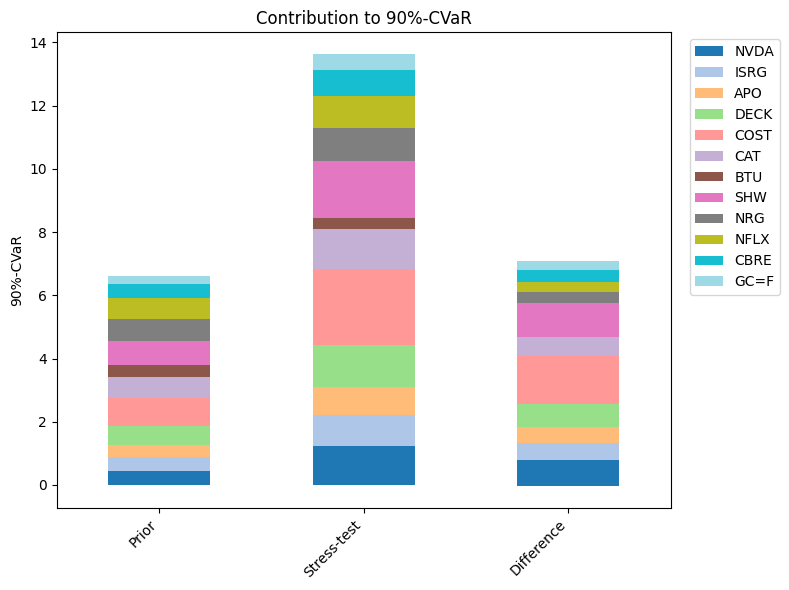

In [33]:
S_sim = 10000
H = 21
np.random.seed(1337)

mu_H = means * H
cov_H = covariance_matrix * H

log_return_sim = np.random.multivariate_normal(mu_H, cov_H, S_sim)
discrete_return_sim = np.exp(log_return_sim - np.diag(cov_H) / 2) - 1
discrete_return_sim = pd.DataFrame(discrete_return_sim, columns=pnl.columns)

gspc_idx = list(pnl.columns).index('^GSPC')
gspc_stress_mean = -0.1

p_prior = np.ones((S_sim, 1)) / S_sim
A = np.ones((1, S_sim))
A = np.vstack((A, discrete_return_sim.values[:, gspc_idx]))
b = np.array([[1., gspc_stress_mean]]).T

q_stress = ft.entropy_pooling(p_prior, A, b)

relative_entropy = q_stress.T @ (np.log(q_stress) - np.log(p_prior))
effective_scenarios = np.exp(-relative_entropy)
print(f'Effective scenarios: {np.round(effective_scenarios[0, 0] * 100, 2)}%')
print(f'Relative entropy: {np.round(relative_entropy[0, 0] * 100, 2)}%')

chosen_exposure = exposure_20
investable_idx = np.where(investable_mask)[0]
investable_names = [pnl.columns[i] for i in investable_idx]
investable_exposure = chosen_exposure[investable_mask]
R_sim_investable = discrete_return_sim.values[:, investable_mask]

def cvar_contributions(weights, returns, probs, alpha=0.9):
    pf_returns = returns @ weights
    sorted_idx = np.argsort(pf_returns)
    sorted_probs = probs[sorted_idx].flatten()
    cum_probs = np.cumsum(sorted_probs)
    tail_mask = cum_probs <= (1 - alpha)
    tail_idx = sorted_idx[tail_mask]
    tail_probs = probs[tail_idx].flatten()
    tail_probs = tail_probs / tail_probs.sum()
    contributions = np.zeros(len(weights))
    for i in range(len(weights)):
        contributions[i] = weights[i] * np.sum(tail_probs * returns[tail_idx, i])
    return -contributions

prior_cvar = cvar_contributions(investable_exposure, R_sim_investable, p_prior, alpha)
stress_cvar = cvar_contributions(investable_exposure, R_sim_investable, q_stress, alpha)
diff_cvar = stress_cvar - prior_cvar

results = pd.DataFrame({
    'Exposure': np.round(investable_exposure * 100, 2),
    'Prior 90%-CVaR': np.round(prior_cvar * 100, 2),
    'Stress 90%-CVaR': np.round(stress_cvar * 100, 2),
    'Difference': np.round(diff_cvar * 100, 2)
}, index=investable_names)

results.loc['Sum'] = results.sum()
print(f"Stress: GSPC mean = {gspc_stress_mean*100:.0f}% over {H} days")
display(results)

plot_df = pd.DataFrame({
    'Prior': prior_cvar * 100,
    'Stress-test': stress_cvar * 100,
    'Difference': diff_cvar * 100
}, index=investable_names)

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.T.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.set_ylabel('90%-CVaR')
ax.set_title('Contribution to 90%-CVaR')
ax.legend(title='', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()